<a href="https://colab.research.google.com/github/biswaroop1547/pytorch_tests/blob/master/VAE_on_MNIST_LETTERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

trainset = torchvision.datasets.EMNIST(root='../data/EMNIST_LETTERS',
# trainset = torchvision.datasets.CIFAR10(root='../data/CIFAR10',
                                       train = True,
                                        split = 'letters',
                                      #  download = True,
                                        download = False,
                                       transform = transform)


# testset = torchvision.datasets.CIFAR10(root='../data/CIFAR10', 
testset = torchvision.datasets.EMNIST(root='../data/EMNIST_LETTERS',
                                      train = False,
                                       split = 'letters',
                                      # download = True,
                                       download = False,
                                      transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                         batch_size=16, 
                                         shuffle = True, 
                                         num_workers=4)


testloader = torch.utils.data.DataLoader(testset, 
                                        batch_size=16, 
                                        shuffle = False, 
                                        num_workers = 4)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes = ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z')

In [9]:
torch.cuda.empty_cache()

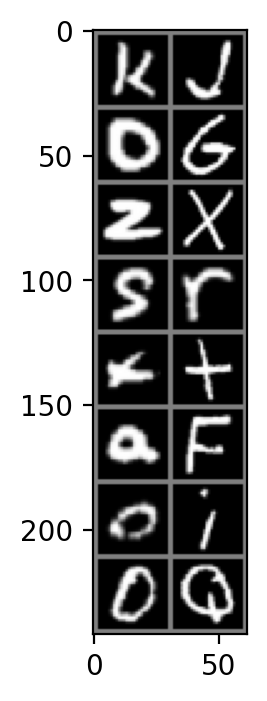

       k        o        z        s        x        a        o        o        j        g        x        r        t        f        i        q


In [115]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(num=None, figsize=(6, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(np.transpose(npimg, (2, 1, 0)))
    plt.show()

dataiter = iter(trainloader)
imgs, labels = dataiter.next()
labels = labels - 1
imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%8s' % classes[labels[i]] for i in range(len(labels))))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
imgs.size()

torch.Size([16, 1, 28, 28])

In [265]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1e = nn.Conv2d(1, 6, 5)
        self.batchnorm1e = nn.BatchNorm2d(6)
        self.conv2e = nn.Conv2d(6, 18, 5)
        self.batchnorm2e = nn.BatchNorm2d(18)
        self.conv3e = nn.Conv2d(18, 48, 7)
        self.batchnorm3e = nn.BatchNorm2d(48)
        self.fc_before = nn.Linear(48*14*14, 26)
        self.batchnorm_before = nn.BatchNorm1d(26)
        self.fc11 = nn.Linear(26, 26)
        self.fc12 = nn.Linear(26, 26)
        

        # self.latent_vec = nn.Linear(48*14*14, 32*6*6)
        self.fc_after = nn.Linear(26, 24*6*6)
        self.batchnorm_after = nn.BatchNorm1d(24*6*6)
        self.conv3d = nn.ConvTranspose2d(24, 18, 11)
        self.batchnorm3d = nn.BatchNorm2d(18)
        self.conv2d = nn.ConvTranspose2d(18, 6, 9)
        self.batchnorm2d = nn.BatchNorm2d(6)
        self.conv1d = nn.ConvTranspose2d(6, 1, 5)
        

    def encoder(self, x):
        x = F.relu(self.batchnorm1e(self.conv1e(x)))
        x = F.relu(self.batchnorm2e(self.conv2e(x)))
        x = F.relu(self.batchnorm3e(self.conv3e(x)))
        # print(x.size())
        x = x.view(x.size()[0], -1)
        x = F.relu(self.batchnorm_before(self.fc_before(x)))
        mu = self.fc11(x)
        logvar = self.fc12(x)
        # print(x.size())
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)

        return mu + std*eps

    
    def decoder(self, z):
        # print("inside decoder : ", z.size())
        z = F.relu(self.batchnorm_after(self.fc_after(z)))
        z = z.view(-1, 24, 6, 6)
        # print("inside decoder after reshape : ", z.size())
        x = F.relu(self.batchnorm3d(self.conv3d(z)))
        x = F.relu(self.batchnorm2d(self.conv2d(x)))
        x = self.conv1d(x)
        # print("final shape : ", x.size())
        return x
    
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        # x = F.relu(self.latent_vec(x))
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar
        
    

In [266]:
net = Net()
net.to(device)


Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1e): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1e): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2e): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2e): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3e): Conv2d(18, 48, kernel_size=(7, 7), stride=(1, 1))
  (batchnorm3e): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_before): Linear(in_features=9408, out_features=26, bias=True)
  (batchnorm_before): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc11): Linear(in_features=26, out_features=26, bias=True)
  (fc12): Linear(in_features=26, out_features=26, bias=True)
  (fc_after): Linear(in_features=26, out_features=864, bias=True)
  (batchnorm_after): BatchNorm1d(864, eps=1e-05, momentum=0.1, affine=True, tra

In [267]:
class Loss(nn.Module):
  def __init__(self):
    super(Loss, self).__init__()
    self.loss = nn.MSELoss(reduction='sum')

  def forward(self, recon_image, real_image, mu, logvar):
    
    MSE = self.loss(recon_image, real_image)

    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KL_divergence

loss_fn = Loss()

In [268]:
optimizer = optim.Adam(net.parameters(), lr=0.0009)
# loss_fn = VAE_loss

Epoch - 1
Loss - 1685.6735052490235 Batches_passed : 200
Loss - 1665.982938232422 Batches_passed : 600
Loss - 1627.7017547607422 Batches_passed : 1200
Loss - 1600.1603839111328 Batches_passed : 2000
Loss - 1581.0778833007812 Batches_passed : 3000
Loss - 1552.5459741210936 Batches_passed : 4200
Loss - 1532.7791052246093 Batches_passed : 5600
Loss - 1497.456196899414 Batches_passed : 7200
Loss - 1489.6865466308593 Batches_passed : 9000
Loss - 1486.374976196289 Batches_passed : 11000
Loss - 1468.6822186279296 Batches_passed : 13200
Loss - 1433.087235107422 Batches_passed : 15600
Loss - 1417.5759997558594 Batches_passed : 18200
Loss - 1425.0795977783202 Batches_passed : 21000
Loss - 1387.337265625 Batches_passed : 24000
Loss - 1368.1551907348633 Batches_passed : 27200
Loss - 1373.4468756103515 Batches_passed : 30600
Loss - 1353.031068725586 Batches_passed : 34200
Loss - 1350.2218420410156 Batches_passed : 38000
Loss - 1350.7299194335938 Batches_passed : 42000
Loss - 1341.8728991699218 Batc

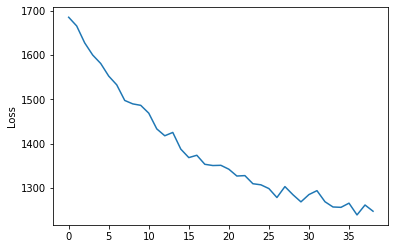

In [276]:
from tqdm import tqdm


loss_track = []
for epoch in range(1):
    
    correct = 0
    total = 0
    running_loss = 0.0
    batch_count = 0
    i = 0
    print(f"Epoch - {epoch + 1}")
    for (inputs, labels) in trainloader:
        net.train()
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = ((labels - 1) / 1.).view(-1, 1)
    
        net.zero_grad()
        
        outputs, mu, logvar = net(inputs)
        loss = loss_fn(outputs, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        
        
#         net.eval()
#         with torch.no_grad():
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()
        if i % 200 == 199:
            batch_count += 1 + i
            batch_loss = running_loss/200
            loss_track.append(batch_loss)
            print(f"Loss - {batch_loss} Batches_passed : {batch_count}")
            running_loss = 0.0
            
        i += 1
#     print(f"Train acc for {total} images : {correct * 100 / total}")
    
#     correct = 0
    total = 0
    total_loss = 0
    
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # images, labels = data
            # labels = ((labels - 1) / 1.).view(-1, 1)
            outputs, mu, logvar = net(images)
            val_loss = loss_fn(outputs, images, mu, logvar)
            total_loss += val_loss
            # _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # correct += (predicted == labels).sum().item()

    # print(f"Test acc for {total} images : {correct * 100 / total}")
    print(f"Val loss for {total} images : {total_loss / total}")

    
import matplotlib.pyplot as plt
plt.plot(loss_track)
plt.ylabel("Loss")
plt.show()

In [277]:
testiter = iter(trainloader)

images, labels = testiter.next()
# labels = labels = ((labels - 1) / 1.).view(-1, 1)
images, labels = images.to(device), labels.to(device)

test_output, mu, logvar = net(images)

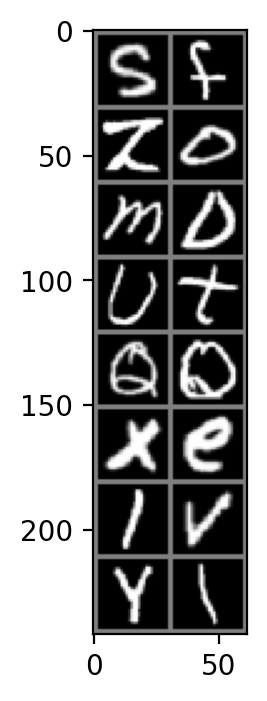

In [278]:
imshow(torchvision.utils.make_grid(images.cpu().detach()))
# imshow(torchvision.utils.make_grid(test_output.cpu().detach()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


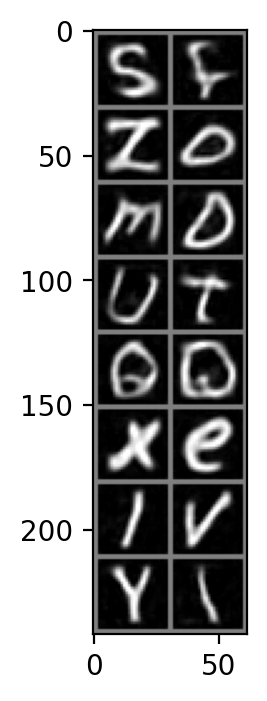

In [279]:
imshow(torchvision.utils.make_grid(test_output.cpu().detach()))

In [280]:
sample = torch.randn(128, 26).to(device)
sample_output = net.decoder(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


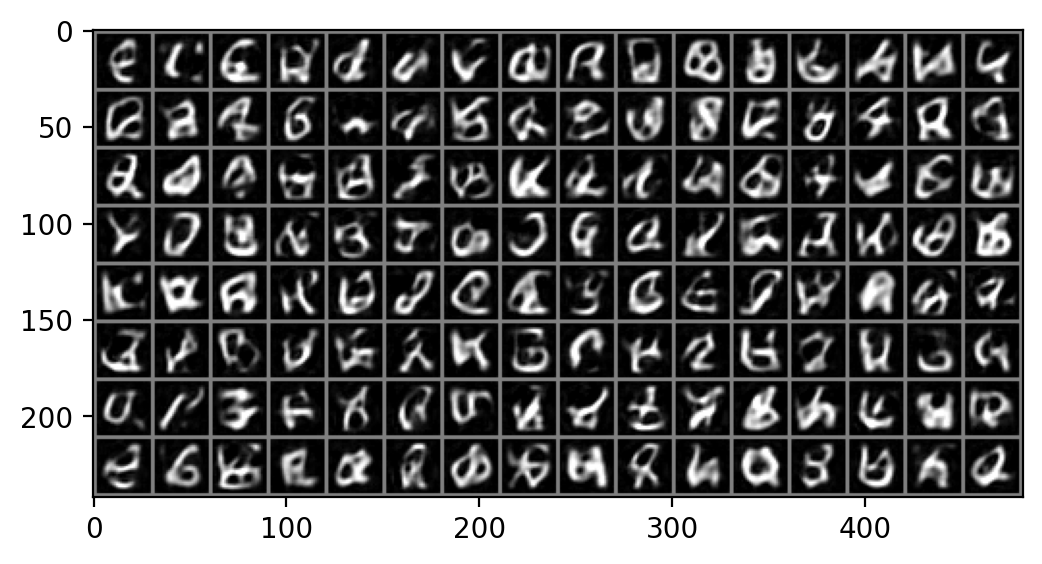

In [281]:
imshow(torchvision.utils.make_grid(sample_output.cpu().detach()))